Knowledge Distillation Tutorial
===============================

######################################################################

Enviroment Setup
----------

In [5]:
!nvidia-smi

Tue Dec  3 18:37:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   53C    P8             N/A /  115W |    3633MiB /   8188MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [7]:
# Print the current working directory
print(f"The notebook is located in: {os.getcwd()}")

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): # Should return True 
    print(f"Using GPU: {torch.cuda.get_device_name(0)}") # Should show your GPU name
else:
    print("Using CPU")

The notebook is located in: d:\Arcade Projects\Knowledge_Distillation_Testing
Using GPU: NVIDIA GeForce RTX 4060


Flowers-102 (102 classes)
------------
split **8189** samples as **1020 (train)**, **1020 (validation)**, and **6149 (test)**.

In [8]:
# Transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the Flower-102 dataset: (train set will later be split into train and val)
trainset = datasets.Flowers102(root='./data', split="train", download=True, transform=transform)
valset = datasets.Flowers102(root='./data', split="val", download=False, transform=transform)
testset = datasets.Flowers102(root='./data', split="test", download=False, transform=transform)

# DataLoaders for train, validation, and test datasets
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Check if dataset loads correctly
print(f"Number of training samples: {len(trainset)}")
print(f"Number of validation samples: {len(valset)}")
print(f"Number of testing samples: {len(testset)}")

100%|██████████| 345M/345M [00:09<00:00, 35.8MB/s] 


Extracting data\flowers-102\102flowers.tgz to data\flowers-102


100%|██████████| 502/502 [00:00<?, ?B/s] 


100%|██████████| 15.0k/15.0k [00:00<?, ?B/s]


Number of training samples: 1020
Number of validation samples: 1020
Number of testing samples: 6149


Defining model classes and utility functions
----------

In [9]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
def train(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(train_loader)}")

        # Validation Step
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() 

        avg_val_loss = val_loss / len(val_loader)  # Average validation loss
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")    

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
	
            # Collect predictions and true labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics using sklearn
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, output_dict=True)

    return cm, report

Cross-entropy runs
-----------------

In [11]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=102).to(device)
train(nn_deep, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)
test_deep = test(nn_deep, test_loader, device)
accuracy_deep = test_deep[1]["accuracy"] * 100
print(f"Teacher Accuracy: {accuracy_deep:.2f}%")

Epoch 1/10, Training Loss: 4.628599688410759
Epoch 1/10, Validation Loss: 4.6137
Epoch 2/10, Training Loss: 4.492883533239365
Epoch 2/10, Validation Loss: 4.2731
Epoch 3/10, Training Loss: 4.012527801096439
Epoch 3/10, Validation Loss: 3.8654
Epoch 4/10, Training Loss: 3.306721992790699
Epoch 4/10, Validation Loss: 3.7603
Epoch 5/10, Training Loss: 2.6165778674185276
Epoch 5/10, Validation Loss: 3.9918
Epoch 6/10, Training Loss: 1.7603958919644356
Epoch 6/10, Validation Loss: 4.5330
Epoch 7/10, Training Loss: 0.9913344755768776
Epoch 7/10, Validation Loss: 5.9238
Epoch 8/10, Training Loss: 0.5448148855939507
Epoch 8/10, Validation Loss: 7.1485
Epoch 9/10, Training Loss: 0.22537309094332159
Epoch 9/10, Validation Loss: 7.7528
Epoch 10/10, Training Loss: 0.20068901777267456
Epoch 10/10, Validation Loss: 7.9878
Teacher Accuracy: 13.68%


In [12]:
# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=102).to(device)

# Re-instantiate the lightweight network:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=102).to(device)

In [13]:
# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


In [14]:
# Print the total number of parameters in each model:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,234,182
LightNN parameters: 291,382


In [15]:
train(nn_light, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)
test_light_ce = test(nn_light, test_loader, device)
accuracy_light_ce = test_light_ce[1]["accuracy"] * 100
print(f"Teacher Accuracy: {accuracy_light_ce:.2f}%")

Epoch 1/10, Training Loss: 4.630090996623039
Epoch 1/10, Validation Loss: 4.5699
Epoch 2/10, Training Loss: 4.327937379479408
Epoch 2/10, Validation Loss: 4.0445
Epoch 3/10, Training Loss: 3.7202884405851364
Epoch 3/10, Validation Loss: 3.7914
Epoch 4/10, Training Loss: 3.194275952875614
Epoch 4/10, Validation Loss: 3.5987
Epoch 5/10, Training Loss: 2.702808491885662
Epoch 5/10, Validation Loss: 3.5844
Epoch 6/10, Training Loss: 2.2599355280399323
Epoch 6/10, Validation Loss: 3.6539
Epoch 7/10, Training Loss: 1.8505308404564857
Epoch 7/10, Validation Loss: 3.8008
Epoch 8/10, Training Loss: 1.3885953221470118
Epoch 8/10, Validation Loss: 4.0552
Epoch 9/10, Training Loss: 1.0183773804455996
Epoch 9/10, Validation Loss: 4.3124
Epoch 10/10, Training Loss: 0.6869167014956474
Epoch 10/10, Validation Loss: 4.6511
Teacher Accuracy: 18.34%


d:\Arcade Projects\Knowledge_Distillation_Testing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Arcade Projects\Knowledge_Distillation_Testing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Arcade Projects\Knowledge_Distillation_Testing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Knowledge distillation run
--------------------------

In [16]:
def train_knowledge_distillation(teacher, student, train_loader, val_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(train_loader)}")

        # Validation Step
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student(inputs)
                loss = ce_loss(outputs, labels)
                val_loss += loss.item() 

        avg_val_loss = val_loss / len(val_loader)  # Average validation loss
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")   

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, val_loader=val_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_light_ce_and_kd = test(new_nn_light, test_loader, device)
accuracy_light_ce_and_kd = test_light_ce_and_kd[1]["accuracy"] * 100
precision_light_ce_and_kd = test_light_ce_and_kd[1]["weighted avg"]["precision"]
recall_light_ce_and_kd = test_light_ce_and_kd[1]["weighted avg"]["recall"]
f1_light_ce_and_kd = test_light_ce_and_kd[1]["weighted avg"]["f1-score"]

# Compare the student test accuracy with and without the teacher, after distillation
print("-----------------------------------------")
print(f"Teacher accuracy: {accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {accuracy_light_ce:.2f}%")

print("-----------------------------------------")
print(f"Student accuracy with CE + KD:")
print(f"Accuracy: {accuracy_light_ce_and_kd:.2f}%")
# Print other value metrics:
print(f"Precision: {precision_light_ce_and_kd:.2f}")
print(f"Recall: {recall_light_ce_and_kd:.2f}")
print(f"F1 Score: {f1_light_ce_and_kd:.2f}")

Epoch 1/10, Training Loss: 7.278578415513039
Epoch 1/10, Validation Loss: 4.5896
Epoch 2/10, Training Loss: 6.8400973826646805
Epoch 2/10, Validation Loss: 4.0485
Epoch 3/10, Training Loss: 5.839757144451141
Epoch 3/10, Validation Loss: 3.7827
Epoch 4/10, Training Loss: 4.932876378297806
Epoch 4/10, Validation Loss: 3.7838
Epoch 5/10, Training Loss: 4.251914657652378
Epoch 5/10, Validation Loss: 3.8985
Epoch 6/10, Training Loss: 3.604799911379814
Epoch 6/10, Validation Loss: 4.0045
Epoch 7/10, Training Loss: 3.125436969101429
Epoch 7/10, Validation Loss: 4.2329
Epoch 8/10, Training Loss: 2.487485446035862
Epoch 8/10, Validation Loss: 4.6665
Epoch 9/10, Training Loss: 1.9159362353384495
Epoch 9/10, Validation Loss: 5.0534
Epoch 10/10, Training Loss: 1.5894012600183487
Epoch 10/10, Validation Loss: 5.2544
-----------------------------------------
Teacher accuracy: 13.68%
Student accuracy without teacher: 18.34%
-----------------------------------------
Student accuracy with CE + KD:
Accu

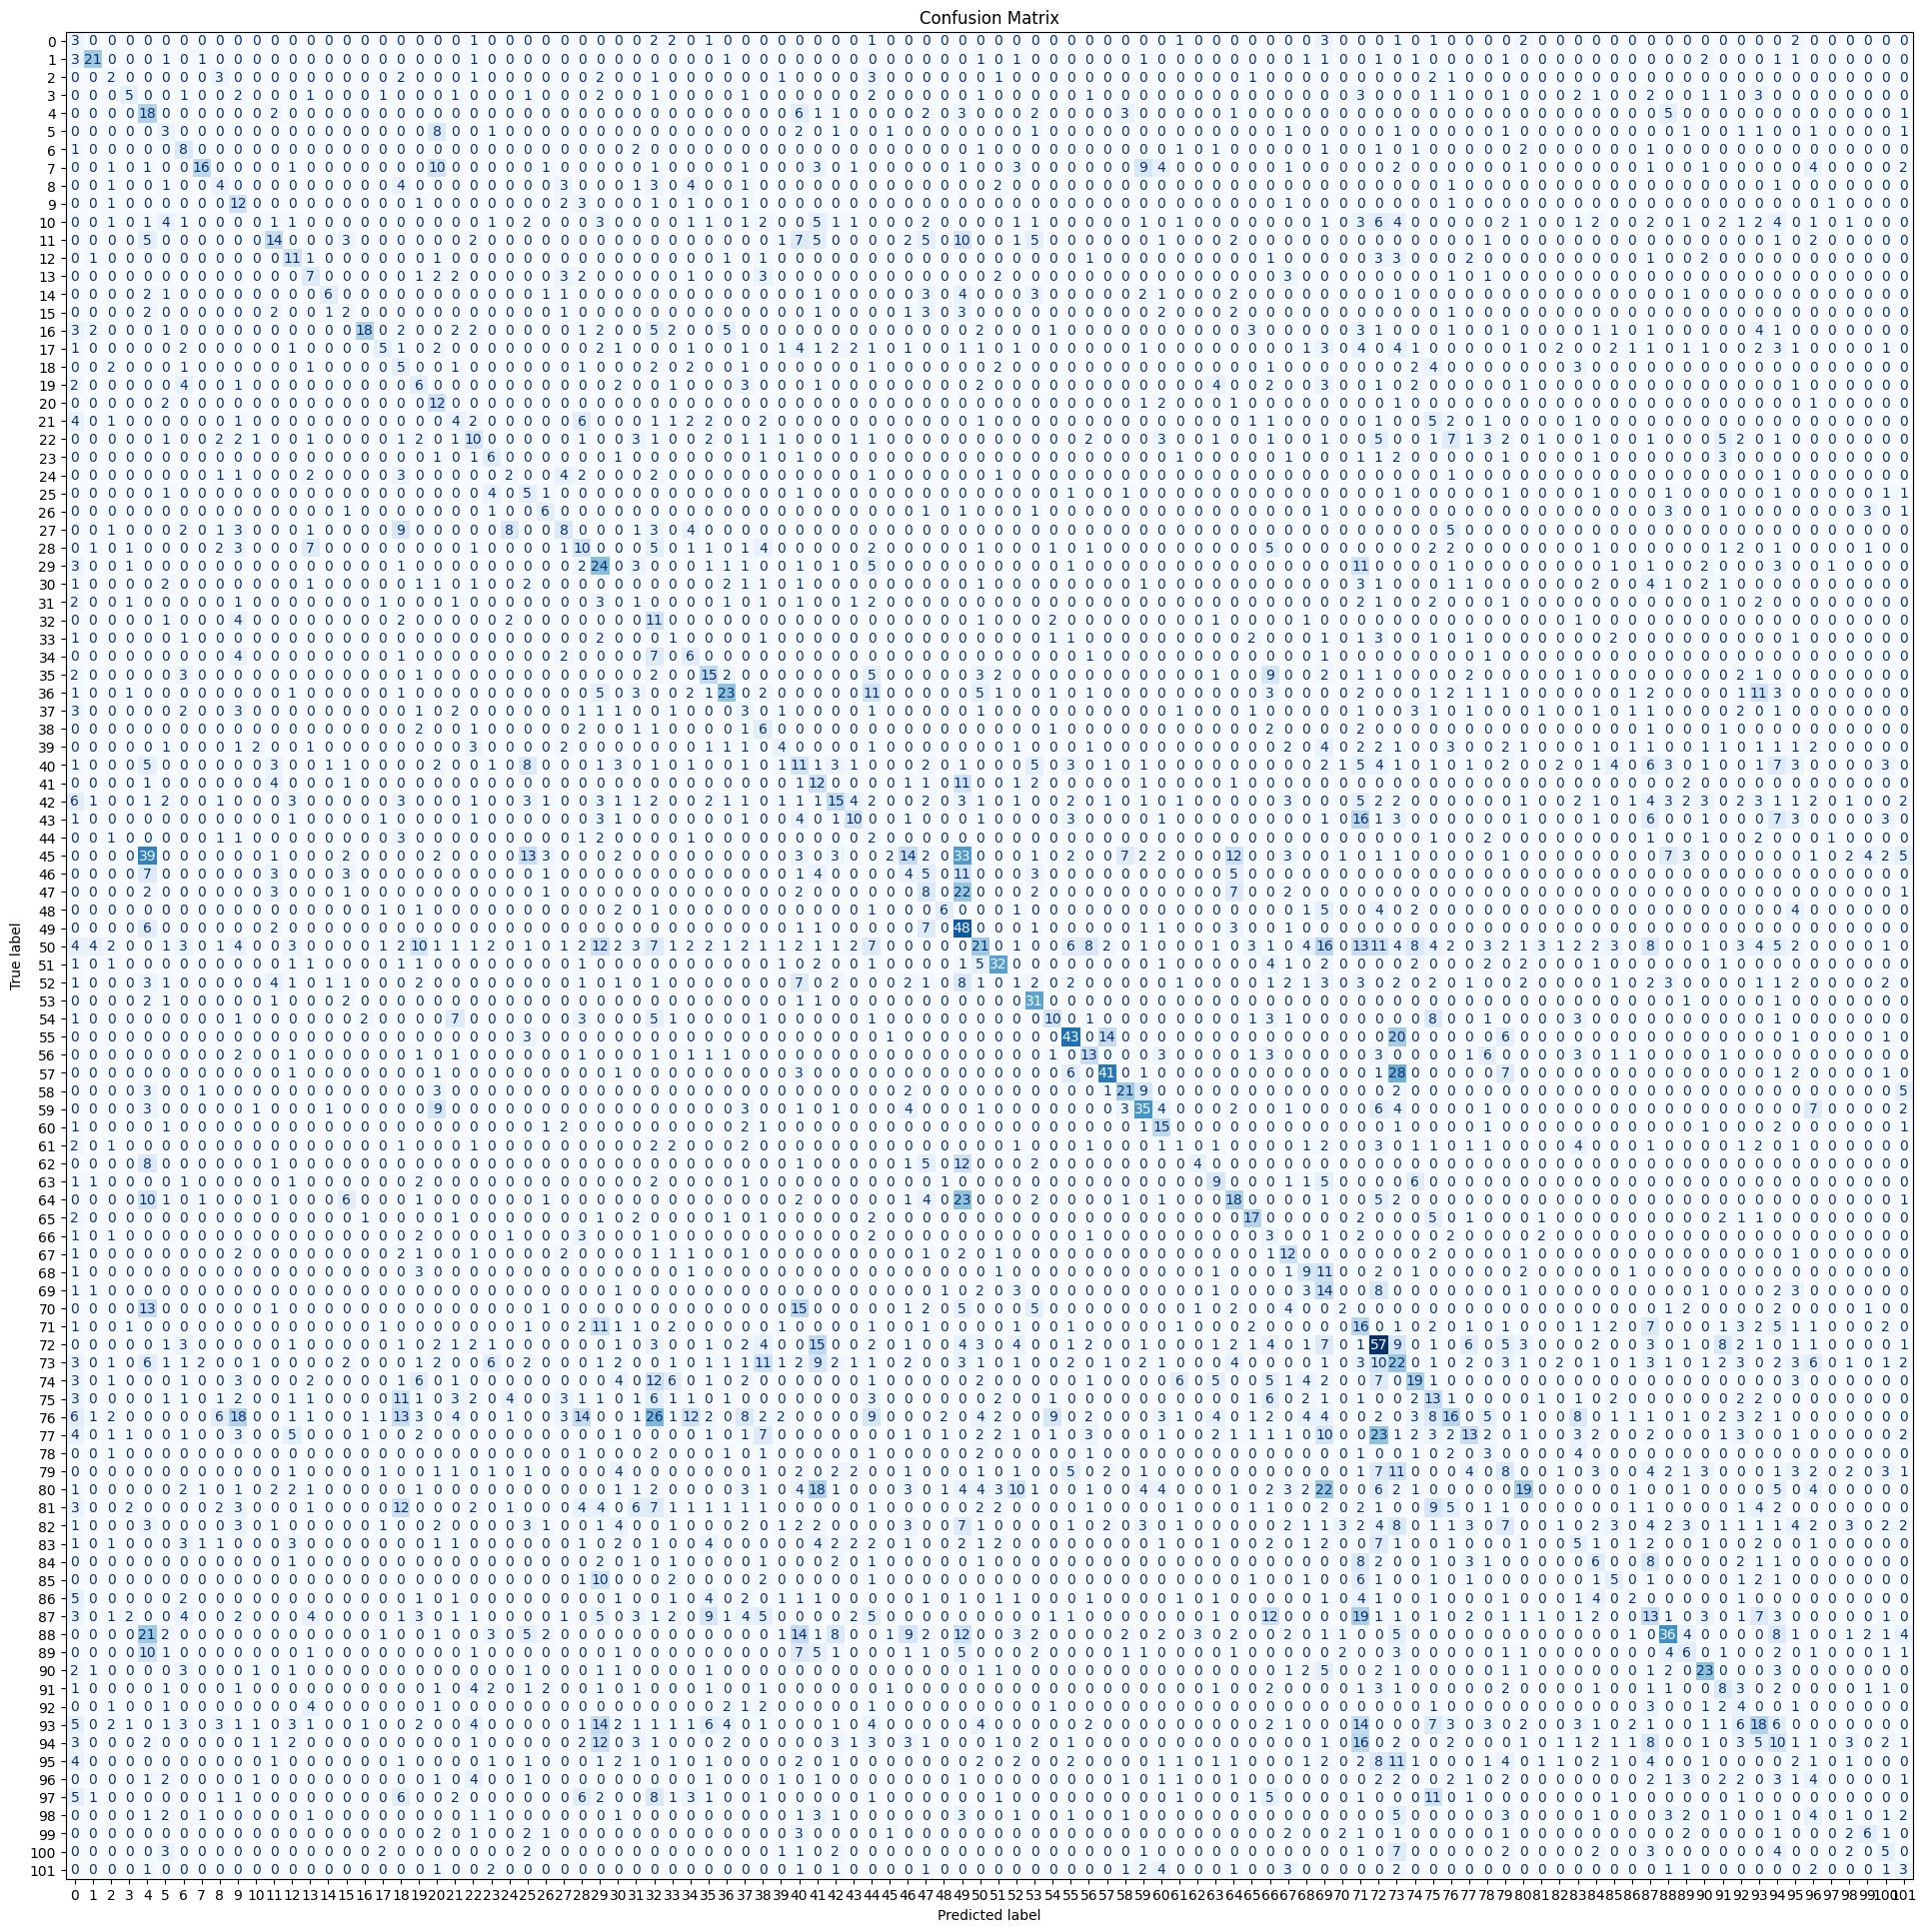

In [17]:
# Generate the confusion matrix
cm = test_light_ce_and_kd[0]

# Visualize the confusion matrix
fig, ax = plt.subplots()
fig.set_size_inches(24, 24)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title("Confusion Matrix")
plt.show()